In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(123)

### Bandit 변수 세팅

In [3]:
N_TRIAL = 2000              # round 수                  > 적정선 찾는 과정 필요
N_ARMS = 16                 # arm 수 (밴딧 수)          > 지면 수
N_FEATURE  = 5              # feature 수                > N개
BEST_ARMS = [3, 7, 9, 15]   # 임의 설정 (최적의 bandit)  > truth 값 존재

In [4]:
def make_design_matrix(n_trial, n_arms, n_feature):     # 임의로 context 생성 (trial, arm, dim_feature)
    available_arms = np.arange(n_arms)
    X = np.array([[np.random.uniform(low=0, high=1, size=n_feature) for _ in available_arms] for _ in np.arange(n_trial)])
    return X

In [5]:
D = make_design_matrix(N_TRIAL, N_ARMS, N_FEATURE)

In [45]:
D.shape

(2000, 16, 5)

In [7]:
def make_theta(n_arms, n_feature, best_arms, bias = 1):     # 임의로 theta 생성 > best에는 1을 더함
    true_theta = np.array([np.random.normal(size=n_feature, scale=1/4) for _ in np.arange(n_arms)])  # 표준편차 = 1/4
    true_theta[best_arms] = true_theta[best_arms] + bias
    return true_theta

In [8]:
theta = make_theta(N_ARMS, N_FEATURE, BEST_ARMS, bias=1)

In [51]:
theta[0]

array([ 0.60524516, -0.08939234,  0.5504962 ,  0.23098787, -0.23563831])

In [9]:
def generate_reward(arm, x, theta, scale_noise = 1/10):
    signal = theta[arm].dot(x)                              # theta[i] > i 번째 밴딧의 
    noise = np.random.normal(scale=scale_noise)
    return (signal + noise)

In [10]:
def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

In [11]:
X = make_design_matrix(n_trial=N_TRIAL, n_arms= N_ARMS, n_feature=N_FEATURE)
true_theta = make_theta(n_arms = N_ARMS, n_feature=N_FEATURE, best_arms=BEST_ARMS)

In [12]:
# Average reward
ave_reward = np.mean([[generate_reward(arm=arm, x=X[t, arm], theta= true_theta) for arm in np.arange(N_ARMS)] for t in np.arange(N_TRIAL)], axis=0)

In [13]:
ave_reward

array([-0.14505537,  0.07005107,  0.27063804,  2.62160151,  0.1690701 ,
       -0.09486946,  0.23158901,  2.03390853,  0.03431275,  3.04526894,
       -0.02397997, -0.08500886,  0.16423942, -0.13694458, -0.11019293,
        2.60830446])

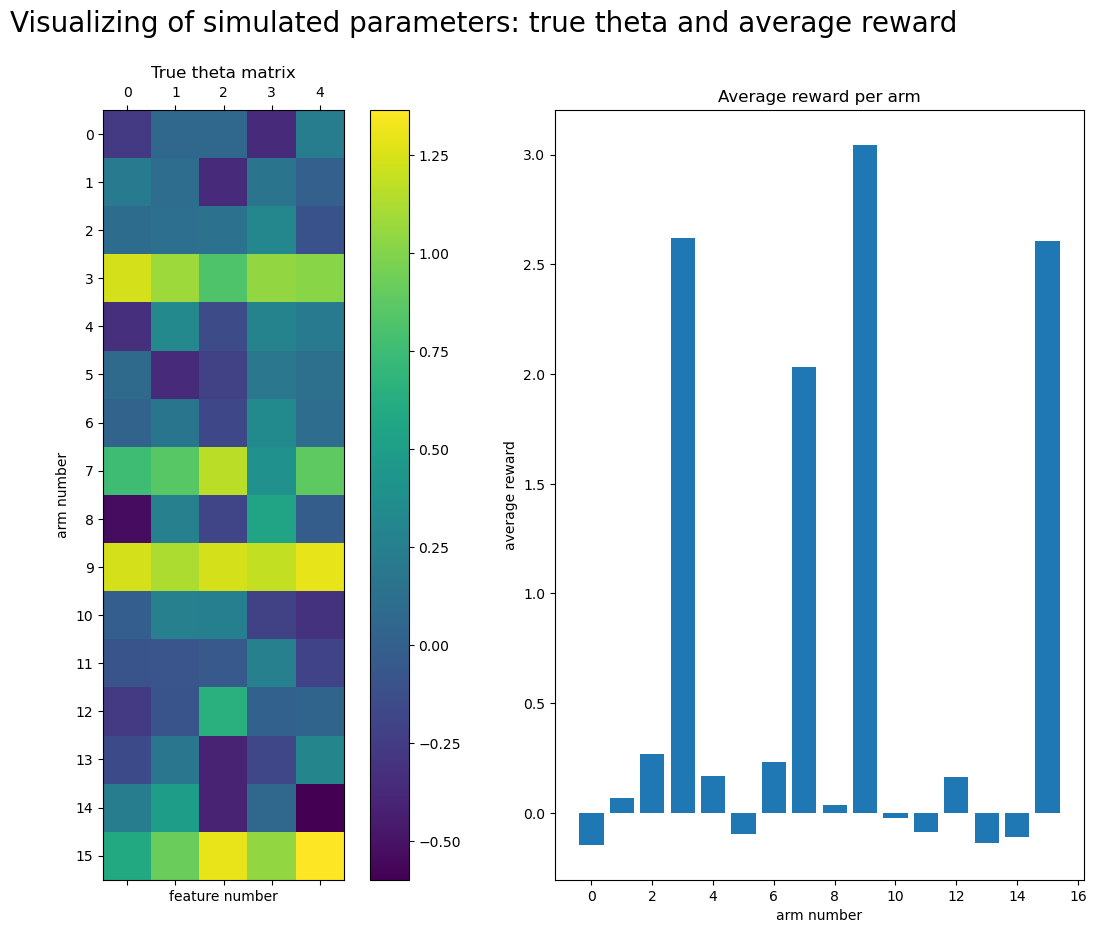

In [14]:
f, (left, right) = plt.subplots(1, 2, figsize=(15, 10))
f.suptitle(t="Visualizing of simulated parameters: true theta and average reward", fontsize=20)
# True theta
left.matshow(true_theta)
f.colorbar(left.imshow(true_theta), ax = left)
left.set_xlabel("feature number")
left.set_ylabel("arm number")
left.set_yticks(np.arange(N_ARMS))
left.set_title("True theta matrix")
# Average reward
right.bar(np.arange(N_ARMS), ave_reward)
right.set_title("Average reward per arm")
right.set_xlabel("arm number")
right.set_ylabel("average reward")
plt.show()

In [15]:
 A = np.array([np.diag(np.ones(shape=6)) for _ in np.arange(16)])

In [16]:
A

array([[[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
      

In [17]:
b = np.array([np.zeros(shape=5) for _ in np.arange(16)])

In [18]:
b

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [19]:
def linUCB_disjoint(alpha, X, generate_reward, true_theta):
    print("linUCB disjoint with exploration parameter alpha: ", alpha)
    n_trial, n_arms, n_feature = X.shape
    # 1. Initialize object
    # 1.1. Output object
    arm_choice = np.empty(n_trial) # store arm choice (integer) for each trial
    r_payoff = np.empty(n_trial) # store payoff (float) for each trial
    theta = np.empty(shape=(n_trial, n_arms, n_feature)) # record theta over each trial (n_arms, n_feature) per trial
    p = np.empty(shape = (n_trial, n_arms)) # predictions for reward of each arm for each trial
    # 1.2 Intermediate object
    A = np.array([np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
    b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])
    # 2. Algo
    for t in np.arange(n_trial):
        # Compute estimates (theta) and prediction (p) for all arms
        for a in np.arange(n_arms):
            inv_A = np.linalg.inv(A[a])
            theta[t, a] = inv_A.dot(b[a])
            p[t, a] = theta[t, a].dot(X[t, a]) + alpha * np.sqrt(X[t, a].dot(inv_A).dot(X[t, a]))
        # Choosing best arms
        chosen_arm = np.argmax(p[t])
        x_chosen_arm = X[t, chosen_arm]
        r_payoff[t] = generate_reward(arm=chosen_arm, x=x_chosen_arm, theta=true_theta)

        arm_choice[t] = chosen_arm
        
        # update intermediate objects (A and b)
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoff[t]*x_chosen_arm
    return dict(theta=theta, p=p, arm_choice=arm_choice, r_payoff=r_payoff)

In [20]:
oracle = np.array([np.max([generate_reward(arm=arm, x=X[t, arm], theta = true_theta) for arm in np.arange(N_ARMS)]) for t in np.arange(N_TRIAL)])

In [21]:
len(oracle)

2000

In [22]:
oracle[0]

3.820459712511478

In [23]:
payoff_random = np.array([generate_reward(arm=np.random.choice(N_ARMS), x= X[t, np.random.choice(N_ARMS)], theta = true_theta) for t in np.arange(X.shape[0])])

In [24]:
payoff_random

array([-0.15349039, -0.02202609, -0.18839785, ...,  0.06006516,
        0.38466929,  0.11904995])

In [25]:
regret_random = make_regret(payoff=payoff_random, oracle=oracle)

In [26]:
alpha_to_test = [0, 1, 2.5, 5, 10, 20]
results_dict = {alpha: linUCB_disjoint(alpha=alpha, X=X, generate_reward=generate_reward, true_theta = true_theta) for alpha in alpha_to_test}

linUCB disjoint with exploration parameter alpha:  0
linUCB disjoint with exploration parameter alpha:  1
linUCB disjoint with exploration parameter alpha:  2.5
linUCB disjoint with exploration parameter alpha:  5
linUCB disjoint with exploration parameter alpha:  10
linUCB disjoint with exploration parameter alpha:  20


In [27]:
def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

In [28]:
def plot_estimates(x, alpha, true_theta=None, abs_ylim = None, ncol = 4):
    print("Estimates plot for alpha: ", alpha)
    if true_theta is not None:
        print("Parameter true_theta has been supplied. Plotting convergence")
    for i, arm in enumerate(np.arange(N_ARMS)):
        plt.subplot(np.ceil(N_ARMS/ncol), ncol, 1+i)
        if true_theta is not None:
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, :]) - true_theta[arm]
        else:
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, ])
        plt.plot(data_to_plot)
        
        if (arm in BEST_ARMS):
            title = 'Arm: ' + str(arm) + " (best)"
        else:
            title = "Arm: " + str(arm)
        plt.title(title)
        
        if abs_ylim is not None:
            plt.ylim([-abs_ylim, abs_ylim])
    plt.legend(["c"+str(feature) for feature in np.arange(N_FEATURE)])

In [29]:
def plot_selected_arms(x, bar_width=0.15):
    for (i, alpha) in enumerate(x):
        xi, yi = np.unique(x[alpha]["arm_choice"], return_counts=True)
        plt.bar(xi + i*bar_width, yi, label="alpha: " + str(alpha), width=bar_width)
    
    plt.xticks(np.arange(N_ARMS) + round(len(x)/2)*bar_width, np.arange(N_ARMS))
    plt.legend()

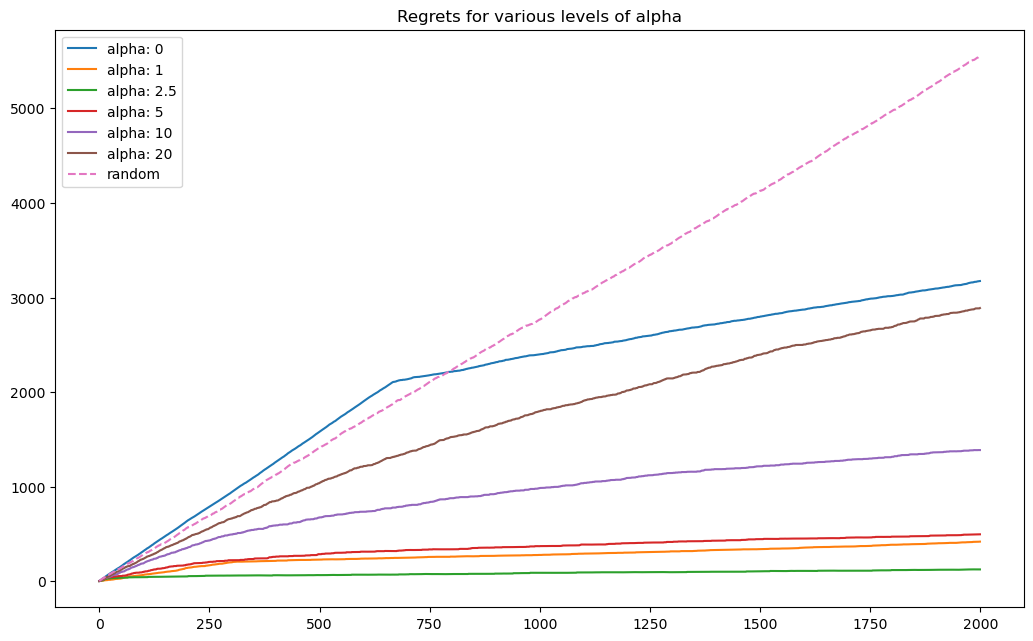

In [30]:
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle)
plt.plot(make_regret(payoff=payoff_random, oracle=oracle), label = "random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

In [33]:
plt.figure(figsize=(12.5, 17.5))
plot_estimates(results_dict, alpha=2.5, true_theta = true_theta, abs_ylim=3/4)

Estimates plot for alpha:  2.5
Parameter true_theta has been supplied. Plotting convergence


ValueError: Number of rows must be a positive integer, not 4.0

<Figure size 1250x1750 with 0 Axes>

In [34]:
plt.figure(figsize=(12.5, 17.5))
plot_estimates(results_dict, alpha=20, true_theta=true_theta, abs_ylim=3/4)

Estimates plot for alpha:  20
Parameter true_theta has been supplied. Plotting convergence


ValueError: Number of rows must be a positive integer, not 4.0

<Figure size 1250x1750 with 0 Axes>

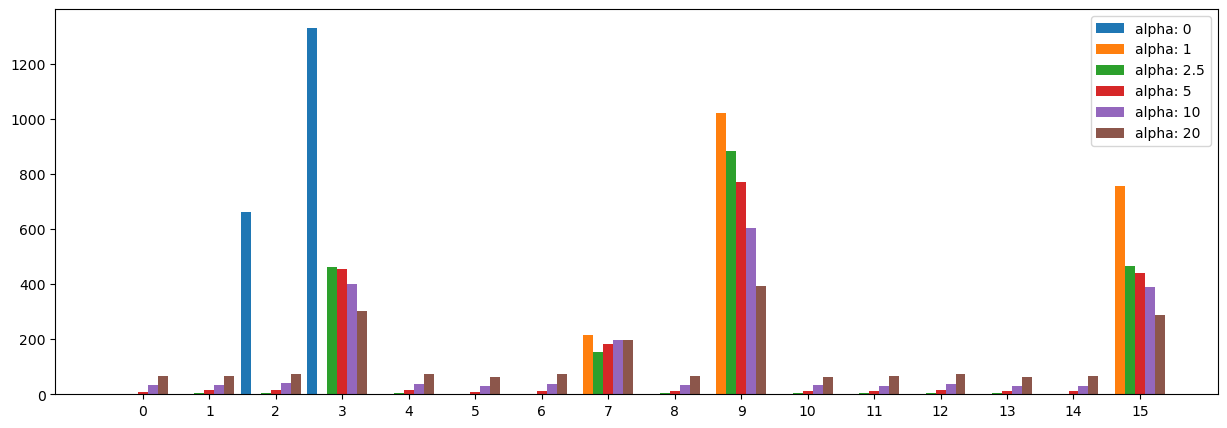

In [35]:
plt.figure(figsize=(15, 5))
plot_selected_arms(results_dict)

---

In [1]:
# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)
        
        # Perform ridge regression to obtain estimate of covariate 
        # coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = np.dot(A_inv, self.b)
        
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T,x) +  self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
        
        return p
    
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x, x.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar

        self.b += reward * x


In [2]:
class linucb_policy():
    
    def __init__(self, K_arms, d, alpha):

        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = 1, d = d, alpha = alpha) for i in range(K_arms)]
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at 
            # time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            
            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current  
                # arm
                candidate_arms = [arm_index]


            # If there is a tie, append to candidate_arms
            if arm_ucb == highest_ucb:
                
                candidate_arms.append(arm_index)
        
        # Choose based on candidate_arms randomly (tie breaker)
        chosen_arm = np.random.choice(candidate_arms)
        
        return chosen_arm

In [3]:
def ctr_simulator(K_arms, d, alpha, data_path):
    
    # Initiate policy
    linucb_policy_object = linucb_policy(K_arms = K_arms, 
                                         d = d, 
                                         alpha = alpha)
    
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    # Open data
    with open(data_path, "r") as f:


        for line_data in f:


            # 1st column: Logged data arm. 
            # Integer data type
            data_arm = int(line_data.split()[0])


            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split()[1])


            # 3rd columns onwards: 100 covariates. Keep in array of 
            # dimensions (100,) with float data type
            covariate_string_list = line_data.split()[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])


            # Find policy's chosen arm based on input covariates at 
            # current time step
            arm_index = linucb_policy_object.select_arm(data_x_array)


            # Check if arm_index is the same as data_arm (ie same 
            # actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy 
            # arms index range from 0 to 9.
            if arm_index + 1 == data_arm:

                # Use reward information for the chosen arm to update
                linucb_policy_object.linucb_arms[arm_index].\
                reward_update(data_reward, data_x_array)


                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
                    
    
    return (aligned_time_steps, 
            cumulative_rewards, 
            aligned_ctr, 
            linucb_policy_object)